In [52]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../')
from xdispersion import RelativeDispersion
import matplotlib.cm as cm
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd

save=False  #save figures or not
namedata = "ExpB"
drifters = xr.open_dataset('./ExpB/fort.1001.np4000nt5993.nc')
#drifters = xr.open_dataset('./QGdaphne-E12e-8/fort.2001.np4000nt3000.nc')

FSLEfilename = "FSLEs/full_velocity/ExpA/fsles_expA.csv" #computed by Matthew
#FSLEfilenamefluct = "FSLEs/no_mean_flow/ExpO/fsles_expO_fluct.csv" #computed by Matthew
#fslefile_daphne="./Data_FLSE/FSLEData_ExpN.csv"

rd = RelativeDispersion(drifters, ragged=False, ID='tracer',
                        xpos='x', uvel='ux', time='time',
                        ypos='y', vvel='uy', coord='polar')

pairs = rd.get_all_pairs()
pairs




<xarray.Dataset> Size: 430MB
Dimensions:   (pair: 5656566, particle: 2)
Coordinates:
  * pair      (pair) int32 23MB 0 1 2 3 4 ... 5656562 5656563 5656564 5656565
  * particle  (particle) int32 8B 0 1
Data variables:
    tlen      (pair) float64 45MB 5.993e+03 5.993e+03 ... 5.993e+03 5.993e+03
    stime     (pair) float64 45MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    r0        (pair) float64 45MB 0.3076 0.6975 0.4532 ... 0.6912 0.6176 0.3354
    pID       (pair, particle) int64 91MB 0 1 0 2 0 ... 3362 3361 3363 3362 3363
    xpos0     (pair, particle) float64 91MB ...
    ypos0     (pair, particle) float64 91MB ...

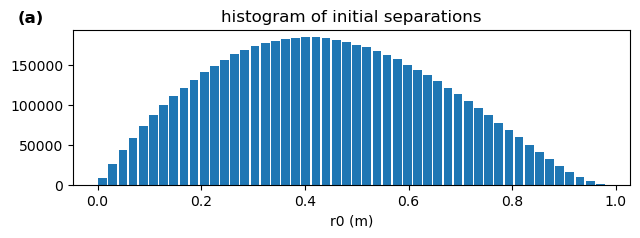

In [53]:
r0_min = pairs.r0.min().item()
r0_max = pairs.r0.max().item()

fig, ax = plt.subplots(figsize=(6.5, 2.5), facecolor='w')

ax.hist(pairs.r0, bins=np.linspace(0, r0_max, 51), rwidth=0.86)
ax.set_xlabel('r0 (m)')
ax.set_title('histogram of initial separations')
ax.text(-0.1, 1.05, '(a)', transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [54]:
# filter original pairs from all pairs
origin_pairs = rd.get_original_pairs(pairs, r0=[0.005, 0.01])
origin_pairs

<xarray.Dataset> Size: 134kB
Dimensions:   (pair: 1768, particle: 2)
Coordinates:
  * pair      (pair) int32 7kB 2999 8940 13983 17098 ... 5639609 5640208 5654749
  * particle  (particle) int32 8B 0 1
Data variables:
    tlen      (pair) float64 14kB 5.993e+03 5.993e+03 ... 5.993e+03 5.993e+03
    stime     (pair) float64 14kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    r0        (pair) float64 14kB 0.006814 0.006275 ... 0.006491 0.006424
    pID       (pair, particle) int64 28kB 0 3000 2 2218 ... 3182 3296 3303 3317
    xpos0     (pair, particle) float64 28kB 0.2403 0.2437 ... 0.3678 0.369
    ypos0     (pair, particle) float64 28kB -0.03887 -0.03297 ... 0.07909

In [ ]:
rx, ry, rxy, r, rpb = rd.separation_measures(origin_pairs) # separations of different components
du, dv, dul, dut, vmi, vmj, uv = rd.velocity_measures(origin_pairs) # velocities of different components


### Two-particle velocity correlation

In [57]:
#rx, ry, rxy, r, du, dv, dul, dut, vmi, vmj, uv = rd.stat_rv(pairs, reduction=None)

vmim =(vmi**2).mean('pair') #vmi is velocity magnitude of particle i.
vmjm =(vmj**2).mean('pair') #vmj velocity magnitude of particle j.
uvm  =  uv.mean('pair')

#Lagrangian velocity correlation
lvc = 2.0 *uvm /(vmim + vmjm) #uv is inner product of two particle's velocitie



/tmp/ipykernel_17533/1509865425.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([0,300])
/tmp/ipykernel_17533/1509865425.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([0,0.5])


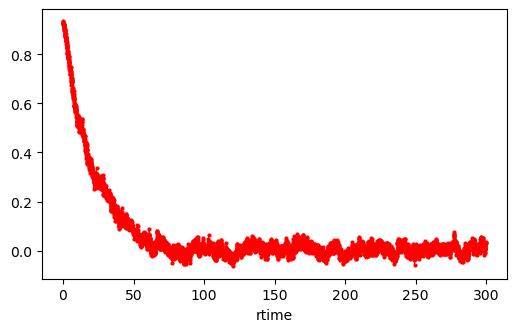

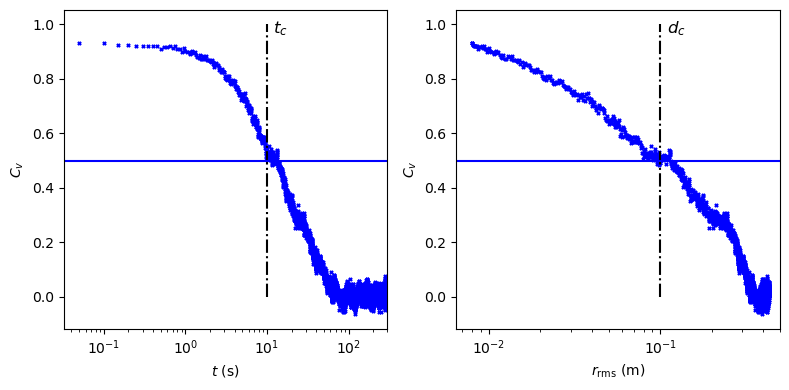

In [86]:
from xdispersion import rel_disp

lvc.plot.line(xscale='linear', yscale='linear', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1)

r2   = rel_disp(r, order=2, mean_at='const-t') #order=2 so 2nd moment of separation
rrms = np.sqrt(r2)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # (rows, cols)
axes[0].scatter(lvc.rtime,lvc.values,marker='x',s=5,color='b')
axes[0].set_xscale('log')
axes[0].set_xlabel(r"$t$ (s)")
axes[0].set_ylabel(r'$C_v$')
axes[0].plot([10,10],[0,1],'-.',color='k')
axes[0].plot([0,300],[0.5,0.5],'-',color='b')
axes[0].set_xlim([0,300])
axes[0].text(12, 0.95, r"$t_c$", rotation=0,
             ha='left', va='bottom', fontsize=12)

axes[1].scatter(rrms,lvc.values,marker='x',s=5,color='b')
axes[1].set_xscale('log')
axes[1].set_xlabel(r"$r_{\rm rms}$ (m)")
axes[1].set_ylabel(r'$C_v$')
axes[1].plot([0.1,0.1],[0,1],'-.',color='k')
axes[1].plot([0,0.5],[0.5,0.5],'-',color='b')
axes[1].set_xlim([0,0.5])
axes[1].text(0.11, 0.95, r"$d_c$", rotation=0,
             ha='left', va='bottom', fontsize=12)


plt.tight_layout()
plt.show()

In [ ]:
from xdispersion.measures import *
from xdispersion.utils import gen_rbins

r2   = rel_disp(r, order=2, mean_at='const-t') #order=2 so 2nd moment of separation
# generate a set of separation bins rbins(n) = r0 * alpha**n
rbins = gen_rbins(0.01, 1, alpha=1.2)

# calculate pFSLE
pFSLE1, upperpFSLE, lowerpFSLE = cen_vul_exp(r, mean_at='const-t', ensemble=100)

# calculate pFSLE manually
K2   = rel_diff(r, mean_at='const-t') #Relative diffusivity
rtmp = np.sqrt(r2)
pFSLE2=K2.values/rtmp.values**2 #this has indeed dimension of inverse time
bin_indices = np.digitize(rtmp.values, rbins)
pFSLE_binned = np.full(len(rbins[1:]), np.nan)
# Compute mean pFSLE in each bin
for i in range(1, len(rbins)):
    mask = bin_indices == i
    if np.any(mask):
        pFSLE_binned[i - 1] = np.nanmean(pFSLE2[mask])
        
# calculate finite amplitude growth rate
FAGR_r, upper, lower = famp_growth_rate(r, mean_at='const-r', rbins=rbins, ensemble=100)
FSLE, upperFSLE, lowerFSLE = fsize_lyap_exp(r, rbins, mean_at='const-r',ensemble=100)


In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 6))
#plt.scatter(rtmp.values,pFSLE,marker='x',color='red')
plt.plot(rtmp.values,pFSLE1)
plt.scatter(rtmp.values, pFSLE2, marker='x', color='red', alpha=0.3, label='Raw data')
plt.plot(rbins[1:], pFSLE_binned, 'o-', color='black', label='Binned mean')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('pFSLE')

In [ ]:
import matplotlib.pyplot as plt

FAGR_r.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1, label='total S2')
plt.fill_between(FAGR_r.rbin, upper, lower, alpha=0.2, color='r', zorder=-5)
plt.title('FAGR')
plt.xlabel('rbin (m)')
_ = plt.ylabel('FAGR (s$^{-1}$)')

In [ ]:
FSLE.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1, label='total S2')
plt.fill_between(FSLE.rbin, upperFSLE, lowerFSLE, alpha=0.2, color='r', zorder=-5)
plt.title('FSLE')
plt.xlabel('rbin (m)')
_ = plt.ylabel('FSLE (s$^{-1}$)')

In [ ]:
#Mathhew's fsle:
fsle = pd.read_csv(FSLEfilename)


fig, ax = plt.subplots(figsize=(5, 6), facecolor='w')
ax.plot(FSLE.rbin,FSLE.values,'o-',color='blue',label='FSLE')
ax.fill_between(FSLE.rbin, upperFSLE, lowerFSLE, alpha=0.2, color='blue', zorder=-5)
ax.plot(FAGR_r.rbin,FAGR_r.values,'o-',color='r',label='FAGR')
ax.fill_between(FAGR_r.rbin, upper, lower, alpha=0.2, color='r', zorder=-5)
#ax.plot(rtmp.values,pFSLE1,label='pFSLE all')
ax.plot(rbins[1:], pFSLE_binned, 'o-', color='g',label='pFSLE binned')
ax.plot(fsle.iloc[:, 1], fsle.iloc[:, 3]/fsle.iloc[1, 3], 'x', color='blue',label="Matthew") 
ax.fill_between(rtmp.values, upperpFSLE, lowerpFSLE, alpha=0.2, color='g', zorder=-5)
ax.plot(rtmp.values,rtmp.values**(-2)/100,color='k')
ax.plot(rtmp.values,rtmp.values**(-2/3)/10,color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,10)
ax.set_xlabel(r"rbin (m)")
ax.set_ylabel(r"FSLE and FAGR and pFSLE")
ax.set_title("Comparisons")
ax.legend(loc='lower left')
